In [1]:
from datasets import Dataset

def my_gen():
    f1 = open("labeled_data_sentences.txt", "r")
    f2 = open("labeled_data_labels.txt", "r")

    sentences = f1.readlines()
    labels = f2.readlines()

    for i in range(len(sentences)):
        yield {"text": sentences[i][:len(sentences[i])-1],
               "label": labels[i][:len(labels[i])-1]}

In [2]:
dataset = Dataset.from_generator(my_gen)

Found cached dataset generator (C:/Users/Jonathan Ipe/.cache/huggingface/datasets/generator/default-a52d2eba600dcdeb/0.0.0)


In [3]:
dataset = dataset.class_encode_column("label")

Loading cached processed dataset at C:\Users\Jonathan Ipe\.cache\huggingface\datasets\generator\default-a52d2eba600dcdeb\0.0.0\cache-7ab10ce251b09a87.arrow


In [9]:
dataset[7726]

{'text': '¯¯±¯Ï¯¯¯ ¯¯³¯¯¯¯¯ ¯¯°¯¯´¯¯ ¯į¯¯¯¯¯¯ ¯¯°¯¯·¯¯ ¯¯±¯¯¯¯¯ ¯¯³¯į¿¯¯ ¯¯·¯¯¯¯¯ ¯¯±¯¯¯¯¯ ¯¯³¯¯¯¯¯ ¯¯·¯¯¿¯¯ ¯¯¿¯¯¯¯¯ ¯¯·¯¯¯¯¯ ¯¯³¯¯¯¯¯ ¯¯±¯¯·¯¯ ¯¯°¯¯¯¯¯ ¯į¯¯¯¯¯¯ ¯ï¯¯¯¯¯¯ ¯į¯¯¯·¯¯ ¯Ï¯¯¯¯¯¯ ¯ï¯¯¯¯¯¯ ¯į¯¯¯¯¯¯ ¯¯°¯¯³¯¯ ¯¯±¯¯¯¯¯ ¯į¯¯¯¯¯¯ ¯¯°¯¯¯¯¯ ¯ï¯¯¯³¯¯ ¯¯°¯¯¯¯¯ ¯į¯¯¯¯¯¯ ¯¯°¯¯¯¯¯ ¯¯±¯¯±¯¯ ¯¯³¯¯¯¯¯ ¯¯·¯¯°¯¯ ¯¯±¯¯¯¯¯ ¯¯¿¯Ŀ¯¯¯ ¯¯Ï¯¯¯¯¯ ¯¯·¯Ï¯¯¯ ¯¯¿¯¯¯¯¯ ¯¯Ï¯·°¯¯ ¯¯ï¯¯¯¯¯ ¯¯¿¯¯¯¯¯ ¯¯Ï¯¯¯¯¯ ¯¯¯¯ů³¯¯ ¯¯·¯³°¯¯ ¯¯¿¯¯¯¯¯ ¯¯³¯¯¯¯¯ ¯¯·¯¯¯¯¯ ¯¯¿¯ĳ¯¯¯ ¯¯Ï¯¿¯¯¯ ¯¯·¯·¯¯¯ ¯¯¿¯³¯¯¯ ¯¯³¯Ï°¯¯ ¯¯¯¯ï¯¯¯ ¯¯·¯¿±¯¯ ¯¯¯¯Ï¯¯¯ ¯¯¿¯×¯¯¯ ¯¯¯¯¯°¯¯ ¯¯¿¯³¯¯¯ ¯¯¯¯į¯¯¯ ¯ï¯¯¯°¯¯ ¯¯¯¯¿¯¯¯ ¯¯¿¯·¯¯¯ ¯¯·¯³¯¯¯ ¯¯¿¯·¯¯¯',
 'label': 0}

In [10]:
from transformers import GPT2TokenizerFast

tokenizer = GPT2TokenizerFast.from_pretrained("../../BPEtokenizer", max_len=512)
# tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [12]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [13]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Loading cached processed dataset at C:\Users\Jonathan Ipe\.cache\huggingface\datasets\generator\default-a52d2eba600dcdeb\0.0.0\cache-fc878a4293cadfe3.arrow


In [14]:
tokenized_datasets = tokenized_datasets.train_test_split(test_size=0.2)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 32004
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 8001
    })
})

In [15]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("../../models/GPT2-Pretrained", num_labels=9)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at ../../models/GPT2-Pretrained and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
model.config.pad_token_id = model.config.eos_token_id

In [17]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

C:\Temp\ipykernel_25464\2607597888.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [18]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [21]:
import wandb
wandb.init(mode="disabled")

In [22]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="../../models/GPT2-finetuned",
                                  overwrite_output_dir=True, 
                                  evaluation_strategy="steps",
                                  num_train_epochs=1,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=8,
                                  eval_steps=250,
                                  logging_steps=250,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

In [23]:
trainer.train()

  0%|          | 0/4001 [00:00<?, ?it/s]

{'loss': 2.1024, 'learning_rate': 4.687578105473632e-05, 'epoch': 0.06}


  0%|          | 0/1001 [00:00<?, ?it/s]

{'eval_loss': 1.9535741806030273, 'eval_accuracy': 0.2237220347456568, 'eval_runtime': 323.9982, 'eval_samples_per_second': 24.695, 'eval_steps_per_second': 3.09, 'epoch': 0.06}
{'loss': 1.932, 'learning_rate': 4.375156210947263e-05, 'epoch': 0.12}


  0%|          | 0/1001 [00:00<?, ?it/s]

{'eval_loss': 1.894191861152649, 'eval_accuracy': 0.3020872390951131, 'eval_runtime': 231.374, 'eval_samples_per_second': 34.58, 'eval_steps_per_second': 4.326, 'epoch': 0.12}
{'loss': 1.8302, 'learning_rate': 4.0627343164208945e-05, 'epoch': 0.19}


  0%|          | 0/1001 [00:00<?, ?it/s]

{'eval_loss': 1.8001141548156738, 'eval_accuracy': 0.34583177102862145, 'eval_runtime': 228.8523, 'eval_samples_per_second': 34.961, 'eval_steps_per_second': 4.374, 'epoch': 0.19}
{'loss': 1.7355, 'learning_rate': 3.7503124218945266e-05, 'epoch': 0.25}


  0%|          | 0/1001 [00:00<?, ?it/s]

{'eval_loss': 1.6004966497421265, 'eval_accuracy': 0.4255718035245594, 'eval_runtime': 279.9183, 'eval_samples_per_second': 28.583, 'eval_steps_per_second': 3.576, 'epoch': 0.25}
{'loss': 1.6161, 'learning_rate': 3.437890527368158e-05, 'epoch': 0.31}


  0%|          | 0/1001 [00:00<?, ?it/s]

{'eval_loss': 1.5390918254852295, 'eval_accuracy': 0.4574428196475441, 'eval_runtime': 337.4883, 'eval_samples_per_second': 23.707, 'eval_steps_per_second': 2.966, 'epoch': 0.31}
{'loss': 1.5118, 'learning_rate': 3.1254686328417895e-05, 'epoch': 0.37}


  0%|          | 0/1001 [00:00<?, ?it/s]

{'eval_loss': 1.4712923765182495, 'eval_accuracy': 0.47794025746781654, 'eval_runtime': 120.1283, 'eval_samples_per_second': 66.604, 'eval_steps_per_second': 8.333, 'epoch': 0.37}
{'loss': 1.5079, 'learning_rate': 2.8130467383154213e-05, 'epoch': 0.44}


  0%|          | 0/1001 [00:00<?, ?it/s]

{'eval_loss': 1.4551591873168945, 'eval_accuracy': 0.49268841394825647, 'eval_runtime': 117.5426, 'eval_samples_per_second': 68.069, 'eval_steps_per_second': 8.516, 'epoch': 0.44}
{'loss': 1.4432, 'learning_rate': 2.5006248437890527e-05, 'epoch': 0.5}


  0%|          | 0/1001 [00:00<?, ?it/s]

{'eval_loss': 1.37241530418396, 'eval_accuracy': 0.51843519560055, 'eval_runtime': 110.9354, 'eval_samples_per_second': 72.123, 'eval_steps_per_second': 9.023, 'epoch': 0.5}
{'loss': 1.4013, 'learning_rate': 2.1882029492626845e-05, 'epoch': 0.56}


  0%|          | 0/1001 [00:00<?, ?it/s]

{'eval_loss': 1.3722577095031738, 'eval_accuracy': 0.5179352580927384, 'eval_runtime': 132.7487, 'eval_samples_per_second': 60.272, 'eval_steps_per_second': 7.541, 'epoch': 0.56}
{'loss': 1.2714, 'learning_rate': 1.8757810547363162e-05, 'epoch': 0.62}


  0%|          | 0/1001 [00:00<?, ?it/s]

{'eval_loss': 1.286491870880127, 'eval_accuracy': 0.5535558055243095, 'eval_runtime': 125.0776, 'eval_samples_per_second': 63.968, 'eval_steps_per_second': 8.003, 'epoch': 0.62}
{'loss': 1.2729, 'learning_rate': 1.5633591602099477e-05, 'epoch': 0.69}


  0%|          | 0/1001 [00:00<?, ?it/s]

{'eval_loss': 1.2696741819381714, 'eval_accuracy': 0.5566804149481315, 'eval_runtime': 125.6711, 'eval_samples_per_second': 63.666, 'eval_steps_per_second': 7.965, 'epoch': 0.69}
{'loss': 1.3154, 'learning_rate': 1.2509372656835791e-05, 'epoch': 0.75}


  0%|          | 0/1001 [00:00<?, ?it/s]

{'eval_loss': 1.2343831062316895, 'eval_accuracy': 0.5711786026746657, 'eval_runtime': 183.3372, 'eval_samples_per_second': 43.641, 'eval_steps_per_second': 5.46, 'epoch': 0.75}
{'loss': 1.2553, 'learning_rate': 9.385153711572107e-06, 'epoch': 0.81}


  0%|          | 0/1001 [00:00<?, ?it/s]

{'eval_loss': 1.2018407583236694, 'eval_accuracy': 0.5833020872390952, 'eval_runtime': 125.6436, 'eval_samples_per_second': 63.68, 'eval_steps_per_second': 7.967, 'epoch': 0.81}
{'loss': 1.2174, 'learning_rate': 6.260934766308422e-06, 'epoch': 0.87}


  0%|          | 0/1001 [00:00<?, ?it/s]

{'eval_loss': 1.189359188079834, 'eval_accuracy': 0.5899262592175978, 'eval_runtime': 123.213, 'eval_samples_per_second': 64.936, 'eval_steps_per_second': 8.124, 'epoch': 0.87}
{'loss': 1.2063, 'learning_rate': 3.136715821044739e-06, 'epoch': 0.94}


  0%|          | 0/1001 [00:00<?, ?it/s]

{'eval_loss': 1.1591697931289673, 'eval_accuracy': 0.5946756655418073, 'eval_runtime': 127.915, 'eval_samples_per_second': 62.549, 'eval_steps_per_second': 7.826, 'epoch': 0.94}
{'loss': 1.2107, 'learning_rate': 1.2496875781054738e-08, 'epoch': 1.0}


  0%|          | 0/1001 [00:00<?, ?it/s]

{'eval_loss': 1.1537926197052002, 'eval_accuracy': 0.5978002749656293, 'eval_runtime': 87.9862, 'eval_samples_per_second': 90.935, 'eval_steps_per_second': 11.377, 'epoch': 1.0}
{'train_runtime': 5360.9652, 'train_samples_per_second': 5.97, 'train_steps_per_second': 0.746, 'train_loss': 1.4893368711414352, 'epoch': 1.0}


TrainOutput(global_step=4001, training_loss=1.4893368711414352, metrics={'train_runtime': 5360.9652, 'train_samples_per_second': 5.97, 'train_steps_per_second': 0.746, 'train_loss': 1.4893368711414352, 'epoch': 1.0})

In [24]:
trainer.save_model("../../models/GPT2-finetuned")

In [36]:
trainer.state.log_history

[{'loss': 2.1024,
  'learning_rate': 4.687578105473632e-05,
  'epoch': 0.06,
  'step': 250},
 {'eval_loss': 1.9535741806030273,
  'eval_accuracy': 0.2237220347456568,
  'eval_runtime': 323.9982,
  'eval_samples_per_second': 24.695,
  'eval_steps_per_second': 3.09,
  'epoch': 0.06,
  'step': 250},
 {'loss': 1.932,
  'learning_rate': 4.375156210947263e-05,
  'epoch': 0.12,
  'step': 500},
 {'eval_loss': 1.894191861152649,
  'eval_accuracy': 0.3020872390951131,
  'eval_runtime': 231.374,
  'eval_samples_per_second': 34.58,
  'eval_steps_per_second': 4.326,
  'epoch': 0.12,
  'step': 500},
 {'loss': 1.8302,
  'learning_rate': 4.0627343164208945e-05,
  'epoch': 0.19,
  'step': 750},
 {'eval_loss': 1.8001141548156738,
  'eval_accuracy': 0.34583177102862145,
  'eval_runtime': 228.8523,
  'eval_samples_per_second': 34.961,
  'eval_steps_per_second': 4.374,
  'epoch': 0.19,
  'step': 750},
 {'loss': 1.7355,
  'learning_rate': 3.7503124218945266e-05,
  'epoch': 0.25,
  'step': 1000},
 {'eval_los

In [26]:
with open("../../training-logs/", 'w') as f:
    for state in trainer.state.log_history:
        f.write(f"{state}\n")

In [27]:
import matplotlib.pyplot as plt

In [28]:
train_loss_list = []
eval_loss_list = []
eval_acc_list = []
epoch_train_list = []
epoch_eval_list = []


for state in trainer.state.log_history:
    if "loss" in state:
        train_loss_list.append(state["loss"])
        epoch_train_list.append(state["epoch"])
    elif "eval_loss" in state:
        eval_loss_list.append(state["eval_loss"])
        eval_acc_list.append(state["eval_accuracy"])
        epoch_eval_list.append(state["epoch"])

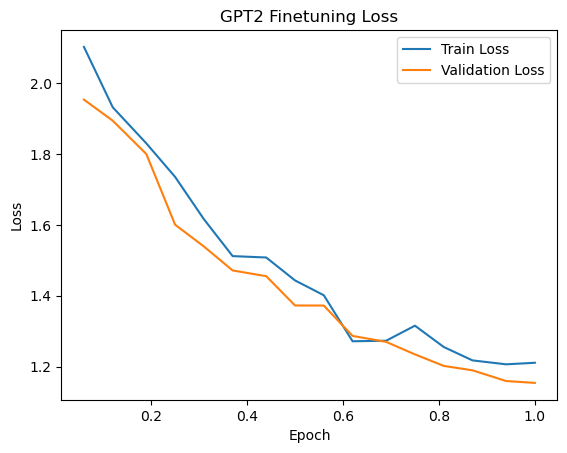

In [32]:
plt.plot(epoch_train_list, train_loss_list)
plt.plot(epoch_eval_list, eval_loss_list)
plt.title("GPT2 Finetuning Loss")
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

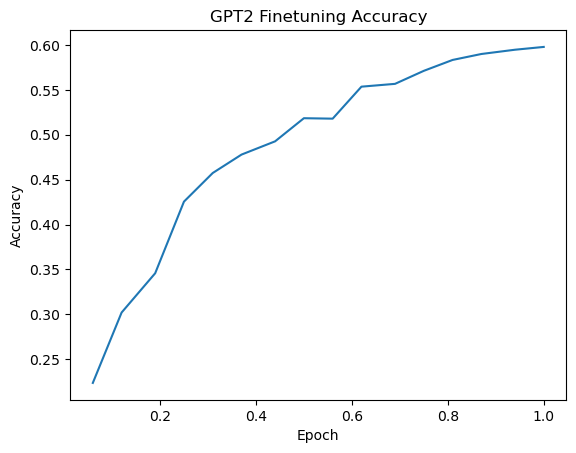

In [31]:
plt.plot(epoch_eval_list, eval_acc_list)
plt.title("GPT2 Finetuning Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()